![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Ejemplo de regularización con regresión logística

## Aprendizaje Automático Aplicado

## Maestría en Ciencia de Datos

[Abrir en google Colab](https://colab.research.google.com/drive/1jrhdrhGMZN3bsVorOU42eJgKK7Xpkm2p?usp=sharing)

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement


plt.rcParams['figure.figsize'] = (10,5)
plt.style.use('ggplot')

## 1. Algunas funciones útiles

Esto, antes de agregarle la regularización

In [13]:
def medias_std(x):
    """
    Obtiene un vector de medias y desviaciones estandar para normalizar

    """
    return np.mean(x, axis=0), np.std(x, axis=0)

def normaliza(x, mu, des_std):
    """
    Normaliza los datos x

    """
    return (x - mu) / des_std

def map_poly(grad, x):
    """
    Encuentra las características polinomiales hasta el grado grad de la matriz de datos x, asumiendo que x[:n, 0] es la expansión de orden 1 (los valores de cada atributo)

    """
    if int(grad) < 2:
        raise ValueError('grad debe de ser mayor a 1')

    M, n = x.shape
    atrib = x.copy()
    x_phi = x.copy()
    for i in range(2, int(grad) + 1):
        for comb in combinations_with_replacement(range(n), i):
            x_phi = np.c_[x_phi, np.prod(atrib[:, comb], axis=1)]
    return x_phi

def logistica(z):
    """
    Calcula la función logística para cada elemento de z

    """
    return 1 / (1 + np.exp(-z))

def error_in(x, y, w, b):
    """
    Calcula el error en muestra para la regresión logística

    """
    a = logistica(x @ w + b)
    return -np.nansum(
            np.sum(np.log(a[y > 0.5])) +
            np.sum(np.log(1 - a[y < 0.5]))
        ) / a.shape[0]

def gradiente_error(x, y, w, b):
    """
    Calcula el gradiente de la función de error en muestra.

    """
    M = x.shape[0]
    error = y - logistica(x @ w + b)
    dw = -x.T @ error / M
    db = - error.mean()
    return dw, db

def dg(x, y, w, b, alpha, max_iter=10_000, tol=1e-6, historial=False):
    """
    Descenso de gradiente por lotes

    """
    M, n = x.shape
    hist = [error_in(x, y, w, b)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = gradiente_error(x, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        error = error_in(x, y, w, b)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break
    return w, b, hist

def predictor(x, w, b):
    """
    Predice la clase de cada elemento de x

    """
    return np.where(x @ w + b > 0, 1, 0)


## 2. Regularización

Tomemos una base de datos que si bien es sintética es representativa de una familia de problemas a resolver. Supongamos que estámos opimizando la fase de pruebas dentro de la linea de producción de la empresa Microprocesadores del Noroeste S.A. de C.V.. La idea es reducir el banco de pruebas de cada nuevo microprocesador fabricado y en lugar de hacer 50 pruebas, reducirlas a 2. En el conjunto de datos tenemos los valores que obtuvo cada componente en las dos pruebas seleccionadas, y la decisión que se tomo con cada dispositivo (esta desición se tomo con el banco de 50 reglas). Los datos los podemos visualizar a continuación.

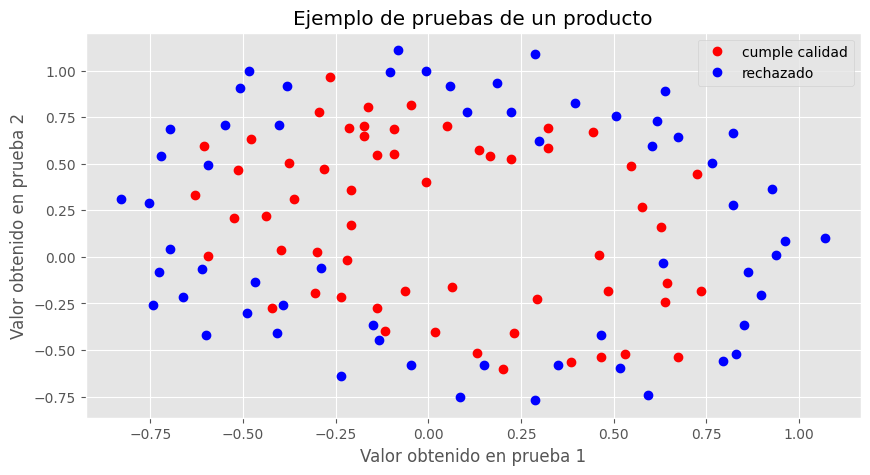

In [14]:
url = "https://github.com/mcd-unison/aaa-curso/raw/main/ejemplos/prod_test.csv"
datos = np.loadtxt(url, comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1]

plt.plot(x[y == 1, 0], x[y == 1, 1], 'or', label='cumple calidad')
plt.plot(x[y == 0, 0], x[y == 0, 1], 'ob', label='rechazado')
plt.title(u'Ejemplo de pruebas de un producto')
plt.xlabel(u'Valor obtenido en prueba 1')
plt.ylabel(u'Valor obtenido en prueba 2')
plt.legend(loc=0)

Cláramente este problema no se puede solucionar con un clasificador lineal (1 orden), por lo que hay que probar otros tipos de clasificadores.

**Completa el código para hacer regresión polinomial para polinomios de orden 2, 4, 6 y 8, y muestra los resultados en una figura. Recuerda que este ejercicio puede tomar bastante tiempo de cómputo. Posiblemente tengas que hacer ajustes en el código para manejar diferentes valores de alpha y max_iter de acuerdo a cada caso**

In [15]:
def plot_separacion2D(x, y, grado, mu, de, w, b):
    """
    Grafica las primeras dos dimensiones (posiciones 1 y 2) de datos en dos dimensiones
    extendidos con un clasificador polinomial así como la separación dada por theta_phi

    """
    if grado < 2:
        raise ValueError('Esta funcion es para graficar separaciones con polinomios mayores a 1')

    x1_min, x1_max = np.min(x[:,0]), np.max(x[:,0])
    x2_min, x2_max = np.min(x[:,1]), np.max(x[:,1])
    delta1, delta2 = (x1_max - x1_min) * 0.1, (x2_max - x2_min) * 0.1

    spanX1 = np.linspace(x1_min - delta1, x1_max + delta1, 600)
    spanX2 = np.linspace(x2_min - delta2, x2_max + delta2, 600)
    X1, X2 = np.meshgrid(spanX1, spanX2)

    X = normaliza(map_poly(grado, np.c_[X1.ravel(), X2.ravel()]), mu, de)

    Z = predictor(X, w, b)
    Z = Z.reshape(X1.shape[0], X1.shape[1])

    # plt.contour(X1, X2, Z, linewidths=0.2, colors='k')
    plt.contourf(X1, X2, Z, 1, cmap=plt.cm.binary_r)
    plt.plot(x[y > 0.5, 0], x[y > 0.5, 1], 'sr', label='clase positiva')
    plt.plot(x[y < 0.5, 0], x[y < 0.5, 1], 'oy', label='clase negativa')
    plt.axis([spanX1[0], spanX1[-1], spanX2[0], spanX2[-1]])

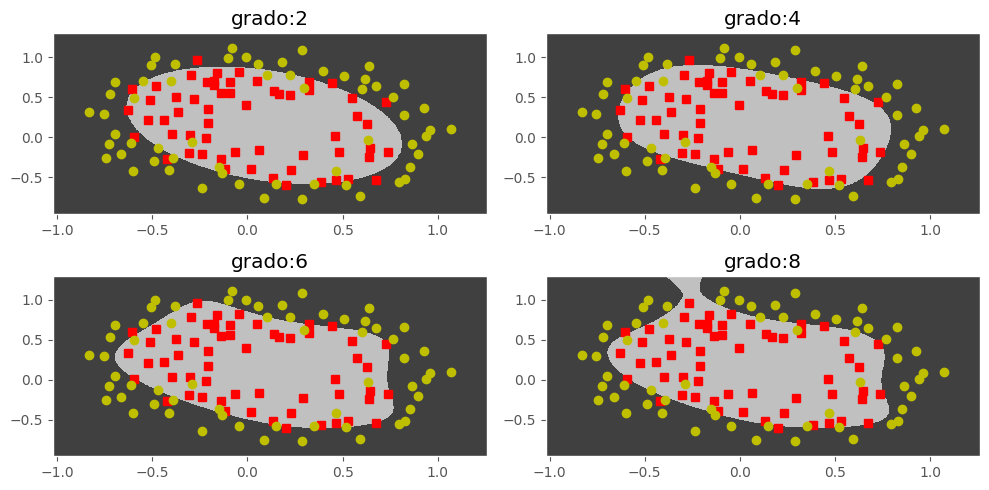

In [17]:
# params
w = np.zeros(x.shape[1])
b = 0

for (i, grado) in enumerate([2, 4, 6, 8]):
    # expansion
    x_poly = map_poly(grado, x)

    # normalizar
    mu, de = medias_std(x_poly)
    x_poly_norm = normaliza(x_poly, mu, de)

    # hparams
    alpha = 1.0 #0.5, 0.25, 0.1
    max_iter = 5000 # 7500, 10000

    # entrenar
    w = np.zeros(x_poly_norm.shape[1])
    b = 0
    w, b, _ = dg(x_poly_norm, y, w, b, alpha=0.1, max_iter=10000, tol=1e-6)

    # grafica
    plt.subplot(2, 2, i + 1)
    plt.title(f'grado:{grado}')
    plot_separacion2D(x, y, grado, mu, de, w, b)

plt.tight_layout()
plt.show()

Como podemos ver del ejercicio anterior, es dificil determinar el grado del polinomio, y en algunos casos es demasiado general (subaprendizaje) y en otros demasiado específico (sobreaprendizaje).

¿Que podría ser la solución?, Una solución posible es utilizar un polinomio de alto grado (o relativamente alto), y utilizar la **regularización** para controlar la generalización del algoritmo, a través de una variable $\lambda$.

Recordemos, la función de costos de la regresión logística con regularización es:

$$
costo(w, b) = E_{in}(w, b) + \frac{\lambda}{M} regu(w),
$$

donde $regu(w)$ es una función de regularización, la cual puede ser $l_1$, $l_2$ u otras, tal como vimos en clase.

**Completa el siguiente código, utilizando una regularización en $L_2$**


In [18]:
def costo(x, y, w, b, lambd):
    """
    Calcula el costo de una w dada para el conjunto de entrenamiento dado
    por y y x, usando regularización

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el valor de lambda en la regularizacion

    @return: un flotante con el valor de pérdida

    """
    costo = 0
    M = x.shape[0]

    #------------------------------------------------------------------------
    z = np.dot(x, w) + b
    h = 1 / (1 + np.exp(-z))  # sigmoide
    costo = (-1 / M) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))  # costo logístico
    reg = (lambd / (2 * M)) * np.sum(w**2)  # regularización L2
    return costo + reg

def grad_regu(x, y, w, b, lambd):
    """
    Calcula el gradiente de la función de costo regularizado para clasificación binaria,
    utilizando una neurona logística, para w y b y conociendo un conjunto de aprendizaje.

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el peso de la regularización

    @return: dw, db, un ndarray de mismas dimensiones que w y un flotante con el cálculo de
             la derivada evaluada en el punto w y b
    """

    M = x.shape[0]
    dw = np.zeros_like(w)
    db = 0.0

    z = np.dot(x, w) + b
    h = 1 / (1 + np.exp(-z))  # sigmoide
    error = h - y
    dw = (1 / M) * np.dot(x.T, error) + (lambd / M) * w  # grad l2
    db = (1 / M) * np.sum(error)

    return dw, db


def dg_regu(x, y, w, b, alpha, lambd, max_iter=10_000, tol=1e-4, historial=False):
    """
    Descenso de gradiente con regularización l2

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param alpha: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param lambd: Un flotante con el valor de la regularización
    @param max_iter: Máximo numero de iteraciones. Por default 10_000
    @param tol: Un flotante pequeño como criterio de paro. Por default 1e-4
    @param historial: Un booleano para saber si guardamos el historial

    @return:
        - w: ndarray de dimensión (n, ) con los pesos;
        - b:  float con el sesgo
        - hist: ndarray de (max_iter,) el historial de error.
                Si historial == False, entonces hist = None.

    """
    M, n = x.shape
    hist = [costo(x, y, w, b, lambd)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = grad_regu(x, y, w, b, lambd)
        w -= alpha * dw
        b -= alpha * db
        error = costo(x, y, w, b, lambd)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break
    return w, b, np.array(hist)


**Desarrolla las funciones y scripts necesarios para realizar la regresión logística con un polinomio de grado `grado` y con cuatro valores de regularización diferentes. Grafica la superficie de separación para cuatro valores diferentes de $\lambda$.**

Realiza varias pruebas para encontrar cual es la relación de `grado` y de $\lambda$ que sea un buen compromiso entre generalizar demasiado o tener sobreaprendizaje.

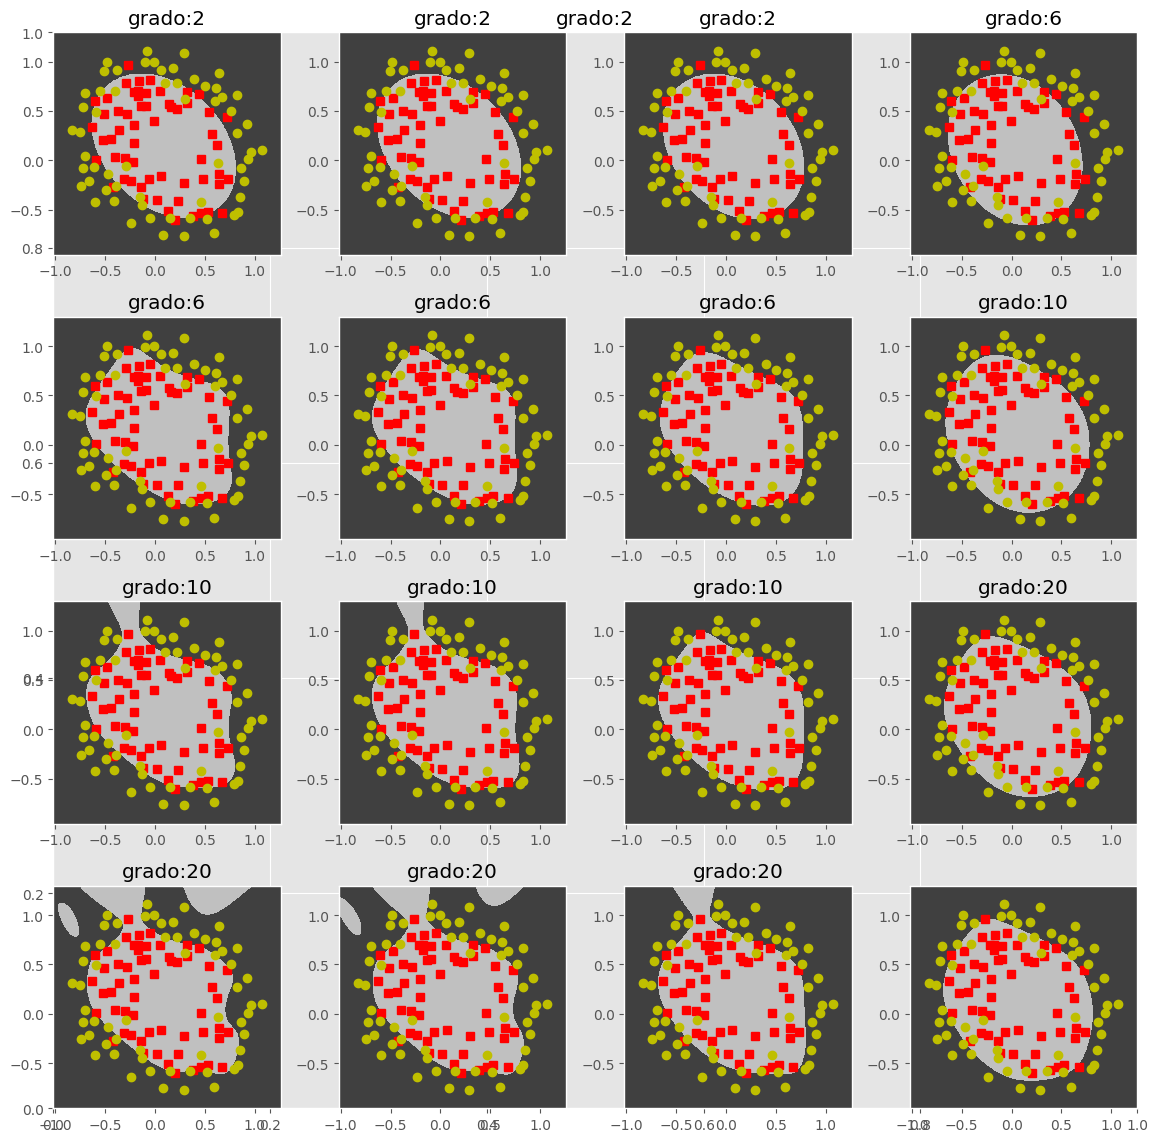

In [19]:
grados = [2, 6, 10, 20]
lambdas = [0.01, 0.1, 1, 10]

plt.figure(figsize=(12, 12))

for i, grado in enumerate(grados):
    for j, lambd in enumerate(lambdas):
        # expansion
        X_poly = map_poly(grado, x)

        # normalizar
        mu, de = medias_std(X_poly)
        x_poly_norm = normaliza(X_poly, mu, de) #x_poly_norm

        # pesos
        n = x_poly_norm.shape[1]
        w = np.zeros(x_poly_norm.shape[1])
        b = 0.0

        # entrenar
        w, b, _ = dg_regu(x_poly_norm, y, w, b, alpha=0.1, lambd=lambd, max_iter=10000, tol=1e-4)

        # grafica
        plt.title(f'grado:{grado}')
        plt.subplot(len(grados), len(lambdas), i * len(lambdas) + j + 1)
        plot_separacion2D(x, y, grado, mu, de, w, b)

plt.tight_layout()
plt.show()

Es muy importante el análisis y las conclusiones que puedas sacar de este ejercicio.

**Escribe aquí tus conclusiones**

Cuando el grado de la regresion logistica es pequeño, la variable de regularizacion parece tener un efecto mas sutil, el cual entre mas se aumenta, "peor" es la estimacion. Mientras que para modelos de gran grado, se necesita una variable de regularizacion grande para "estabilizar" el modelo, ya que para una variable pequeña en gran grado, parece ser que la regresion logistica tiene una mal aproximacion.